# Module 3: First Clinical Prediction Model (Traditional ML)
## Predicting 30-Day Readmission Risk

**Goal:** Build, compare, and interpret two baseline models (Logistic Regression and Decision Tree)
for a clinically meaningful prediction task.

### How to use this notebook
- Run cells top to bottom.
- Keep notes on what changes model behavior.
- This chapter introduces model training with small, reproducible steps.

### Learning objectives
1. Describe the end-to-end clinical ML pipeline before writing model code.
2. Define features (`X`) and label (`y`) for a clinical prediction task.
3. Train a baseline Logistic Regression model and Decision Tree model.
4. Compare metrics that matter clinically, not just accuracy.
5. Explore threshold trade-offs between sensitivity and specificity.
6. Inspect model behavior and review missed high-risk patients.


## Pipeline at a Glance (Read This First)
Before we go step-by-step, here is the full workflow we will follow in this notebook:

`Clinical question -> Data and label setup -> Train/test split -> Train baseline models -> Evaluate at threshold 0.50 -> Tune threshold -> Interpret model -> Error analysis -> Save predictions`

### Where each step appears
1. **Step 1:** Clinical problem and decision context.
2. **Step 2:** Define features (`X`) and label (`y`), then split train/test.
3. **Step 3:** Train Logistic Regression and Decision Tree baselines.
4. **Step 4:** Compare confusion counts at threshold 0.50.
5. **Step 5:** Interactively tune threshold for clinical trade-offs.
6. **Step 6:** Interpret model behavior (coefficients + tree logic).
7. **Step 7:** Review false negatives (missed high-risk patients).
8. **Step 8:** Save predictions for Module 4 evaluation policy work.

Keep this map in mind as you run each section.

Run the next cell for a visual map of this pipeline.


### Visual Pipeline Map
This figure summarizes the full workflow before we dive into each step.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

steps = [
    '1) Clinical
Question',
    '2) Data +
Label Setup',
    '3) Train/Test
Split',
    '4) Train
Baselines',
    '5) Evaluate
@ 0.50',
    '6) Tune
Threshold',
    '7) Interpret +
Error Analysis',
    '8) Save
Predictions',
]

colors = ['#F4A261', '#E9C46A', '#2A9D8F', '#90BE6D', '#577590', '#277DA1', '#4D908E', '#6D597A']

fig, ax = plt.subplots(figsize=(16, 3.4))
ax.set_xlim(0, 8.4)
ax.set_ylim(0, 1)
ax.axis('off')

for i, (label, color) in enumerate(zip(steps, colors), start=1):
    x = i - 0.9
    width = 0.82
    box = FancyBboxPatch(
        (x, 0.22),
        width,
        0.56,
        boxstyle='round,pad=0.02,rounding_size=0.06',
        linewidth=1.2,
        edgecolor='#1f1f1f',
        facecolor=color,
        alpha=0.95,
    )
    ax.add_patch(box)
    ax.text(x + width / 2, 0.5, label, ha='center', va='center', fontsize=10, color='white', weight='bold')

    if i < len(steps):
        ax.annotate('', xy=(x + width + 0.09, 0.5), xytext=(x + width + 0.01, 0.5), arrowprops=dict(arrowstyle='-|>', lw=1.5, color='#333333'))

ax.set_title('Readmission ML Pipeline: Big Picture First', fontsize=14, weight='bold', pad=10)
plt.show()


## Step 1: Clinical Problem and Decision Context
At discharge, a care team wants to identify patients at high risk of 30-day readmission.
The team can only intervene for a limited number of patients, so false negatives and false positives
have different operational consequences.


## Helper Functions
Run this cell once at the start. It auto-configures paths in Google Colab and does nothing harmful on local Jupyter.

In [13]:
import os
import sys
import subprocess
from pathlib import Path

def setup_repo_for_colab(
    repo_url='https://github.com/aaekay/Medical-AI-101.git',
    repo_dir='/content/Medical-AI-101',
    notebook_dir='chapters',
):
    if 'google.colab' not in sys.modules:
        print(f'Local runtime detected. Working directory: {Path.cwd()}')
        return

    repo_path = Path(repo_dir)
    if not repo_path.exists():
        print('Cloning Medical-AI-101 into /content ...')
        subprocess.check_call(['git', 'clone', repo_url, str(repo_path)])

    target = repo_path / notebook_dir
    os.chdir(target)
    print(f'Colab ready. Working directory: {Path.cwd()}')

setup_repo_for_colab()


Local runtime detected. Working directory: /Users/aaekay/Documents/projects/Medical-AI-101/chapters


In [14]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from IPython.display import display

try:
    import ipywidgets as widgets
except ImportError as exc:
    raise ImportError('ipywidgets is required for the threshold demo.') from exc

def resolve_data_path(filename):
    candidates = [Path('../data') / filename, Path('data') / filename]
    for cand in candidates:
        if cand.exists():
            return cand
    raise FileNotFoundError(f'Could not locate {filename} in ../data or data/')

DATA_PATH = resolve_data_path('module_02_cleaned_for_module_03.csv')
df = pd.read_csv(DATA_PATH)
print(f'Loaded {len(df)} rows and {df.shape[1]} columns from {DATA_PATH}.')


Loaded 120 rows and 11 columns from ../data/module_02_cleaned_for_module_03.csv.


In [15]:
display(df.head(8))
print()
print('Class balance:')
print(df['label_readmit_30d'].value_counts(normalize=True).rename('proportion').round(3))


,encounter_id,age,sex_female,sbp,ldl_mg_dl,smoke,comorbidity_count,prior_admissions_12m,insurance_type,race_group,label_readmit_30d
0,10001,64.0,1,130.0,141.3000,0,0.0,1.0,Commercial,Hispanic,0
1,10002,60.0,1,138.3,140.5000,1,0.0,0.0,Commercial,Asian,0
2,10003,66.0,1,145.8,174.3000,1,1.0,3.0,Commercial,Black,1
3,10004,80.0,1,134.2,126.4000,1,3.0,2.0,Commercial,Black,1
4,10005,65.0,1,134.4,149.3000,1,1.0,1.0,Medicaid,Hispanic,0
5,10007,77.0,1,130.9,152.3598,1,2.0,0.0,Commercial,White,0
6,10008,68.0,1,118.9,138.1000,0,6.0,1.0,Commercial,White,0
7,10009,84.0,0,134.0,114.0000,0,6.0,0.0,Commercial,White,0



Class balance:
label_readmit_30d
0    0.792
1    0.208
Name: proportion, dtype: float64


## Step 2: Define Features and Split Data
We use only information available by discharge time.


In [16]:
id_col = 'encounter_id'
target_col = 'label_readmit_30d'

numeric_features = [
    'age',
    'sex_female',
    'sbp',
    'ldl_mg_dl',
    'smoke',
    'comorbidity_count',
    'prior_admissions_12m',
]
categorical_features = ['insurance_type', 'race_group']
feature_cols = numeric_features + categorical_features

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()
encounter_ids = df[id_col].copy()

X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X,
    y,
    encounter_ids,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

print(f'Train rows: {len(X_train)}')
print(f'Test rows: {len(X_test)}')
print(f'Train prevalence: {y_train.mean():.3f}')
print(f'Test prevalence: {y_test.mean():.3f}')


Train rows: 90
Test rows: 30
Train prevalence: 0.211
Test prevalence: 0.200


## Step 3: Train Baseline Models
Model A: Logistic Regression (linear, interpretable coefficients).

Model B: Decision Tree (rule-like, nonlinear splits).


In [17]:
lr_preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

tree_preprocess = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

lr_model = Pipeline([
    ('prep', lr_preprocess),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)),
])

tree_model = Pipeline([
    ('prep', tree_preprocess),
    ('clf', DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, random_state=42)),
])

lr_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)

lr_proba = lr_model.predict_proba(X_test)[:, 1]
tree_proba = tree_model.predict_proba(X_test)[:, 1]


In [18]:
def metrics_from_proba(y_true, proba, threshold=0.5):
    pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred, labels=[0, 1]).ravel()

    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total else np.nan
    precision = tp / (tp + fp) if (tp + fp) else np.nan
    recall = tp / (tp + fn) if (tp + fn) else np.nan
    specificity = tn / (tn + fp) if (tn + fp) else np.nan
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else np.nan
    auc = roc_auc_score(y_true, proba)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall_sensitivity': recall,
        'specificity': specificity,
        'f1': f1,
        'roc_auc': auc,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
    }

lr_metrics = metrics_from_proba(y_test, lr_proba, threshold=0.5)
tree_metrics = metrics_from_proba(y_test, tree_proba, threshold=0.5)

comparison = pd.DataFrame([lr_metrics, tree_metrics], index=['Logistic Regression', 'Decision Tree'])
display(comparison[['accuracy', 'precision', 'recall_sensitivity', 'specificity', 'f1', 'roc_auc']].round(3))


,accuracy,precision,recall_sensitivity,specificity,f1,roc_auc
Logistic Regression,0.700,0.200,0.167,0.833,0.182,0.535
Decision Tree,0.633,0.143,0.167,0.750,0.154,0.486


## Step 4: Confusion Matrix View at Threshold 0.5
Confusion counts make the clinical trade-offs concrete.


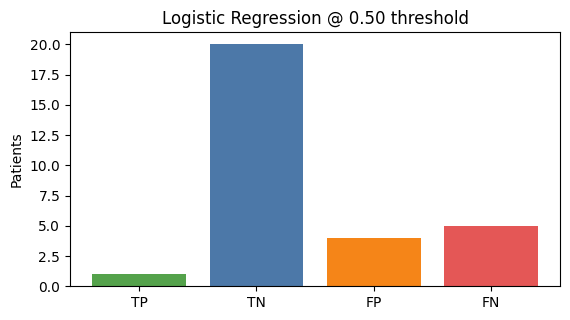

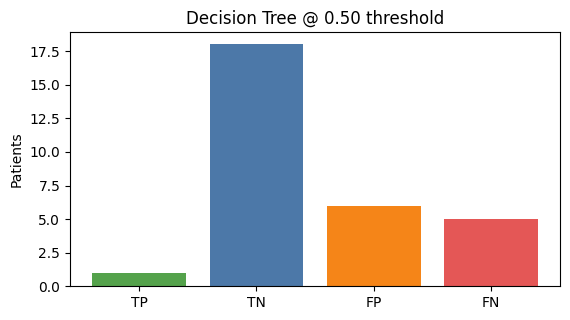

In [19]:
def plot_confusion_counts(metrics, title):
    counts = pd.Series({
        'TP': metrics['tp'],
        'TN': metrics['tn'],
        'FP': metrics['fp'],
        'FN': metrics['fn'],
    })
    fig, ax = plt.subplots(figsize=(5.8, 3.3))
    ax.bar(counts.index, counts.values, color=['#54a24b', '#4c78a8', '#f58518', '#e45756'])
    ax.set_title(title)
    ax.set_ylabel('Patients')
    plt.tight_layout()
    plt.show()

plot_confusion_counts(lr_metrics, 'Logistic Regression @ 0.50 threshold')
plot_confusion_counts(tree_metrics, 'Decision Tree @ 0.50 threshold')


## Step 5: Interactive Threshold Tuning (Logistic Regression)
Lower thresholds usually increase sensitivity (catch more true readmissions) but can increase false positives.


In [20]:
def threshold_demo(threshold=0.50):
    m = metrics_from_proba(y_test, lr_proba, threshold=threshold)
    print(f'Threshold: {threshold:.2f}')
    print(
        f"Accuracy: {m['accuracy']:.3f} | Precision: {m['precision']:.3f} | "
        f"Sensitivity: {m['recall_sensitivity']:.3f} | Specificity: {m['specificity']:.3f}"
    )

    fig, ax = plt.subplots(figsize=(5.8, 3.3))
    labels = ['TP', 'TN', 'FP', 'FN']
    values = [m['tp'], m['tn'], m['fp'], m['fn']]
    colors = ['#54a24b', '#4c78a8', '#f58518', '#e45756']
    ax.bar(labels, values, color=colors)
    ax.set_title('Logistic Regression Confusion Counts')
    ax.set_ylabel('Patients')
    plt.tight_layout()
    plt.show()

widgets.interact(
    threshold_demo,
    threshold=widgets.FloatSlider(
        value=0.50, min=0.10, max=0.90, step=0.05, description='Threshold', continuous_update=False
    ),
)


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Threshold', max=0.9, min=0.…

<function __main__.threshold_demo(threshold=0.5)>

## Step 6: Model Interpretation
Logistic Regression coefficients show directional influence.

Decision Trees show path-based logic.


,feature,coefficient
7,cat__insurance_type_Commercial,-1.115
12,cat__race_group_Black,-0.817
6,num__prior_admissions_12m,0.796
3,num__ldl_mg_dl,0.707
4,num__smoke,0.658
13,cat__race_group_Hispanic,0.580
0,num__age,0.497
8,cat__insurance_type_Medicaid,0.475
5,num__comorbidity_count,0.445
14,cat__race_group_Other,-0.332


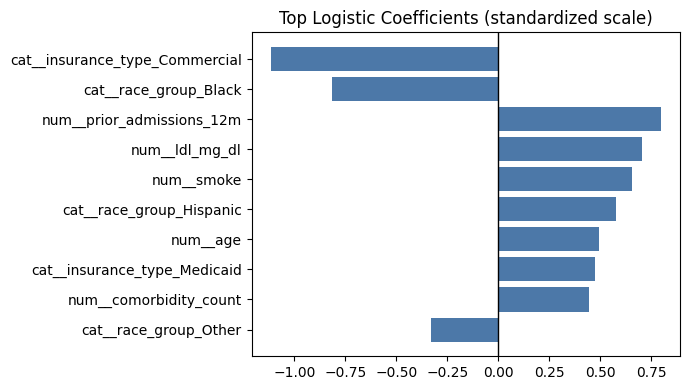

In [21]:
lr_feature_names = lr_model.named_steps['prep'].get_feature_names_out()
lr_coefs = lr_model.named_steps['clf'].coef_[0]
coef_table = pd.DataFrame({'feature': lr_feature_names, 'coefficient': lr_coefs})
coef_table['abs_coefficient'] = coef_table['coefficient'].abs()
coef_table = coef_table.sort_values('abs_coefficient', ascending=False)

display(coef_table[['feature', 'coefficient']].head(12).round(3))

top10 = coef_table.head(10).iloc[::-1]
fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(top10['feature'], top10['coefficient'], color='#4c78a8')
ax.axvline(0, color='black', linewidth=1)
ax.set_title('Top Logistic Coefficients (standardized scale)')
plt.tight_layout()
plt.show()


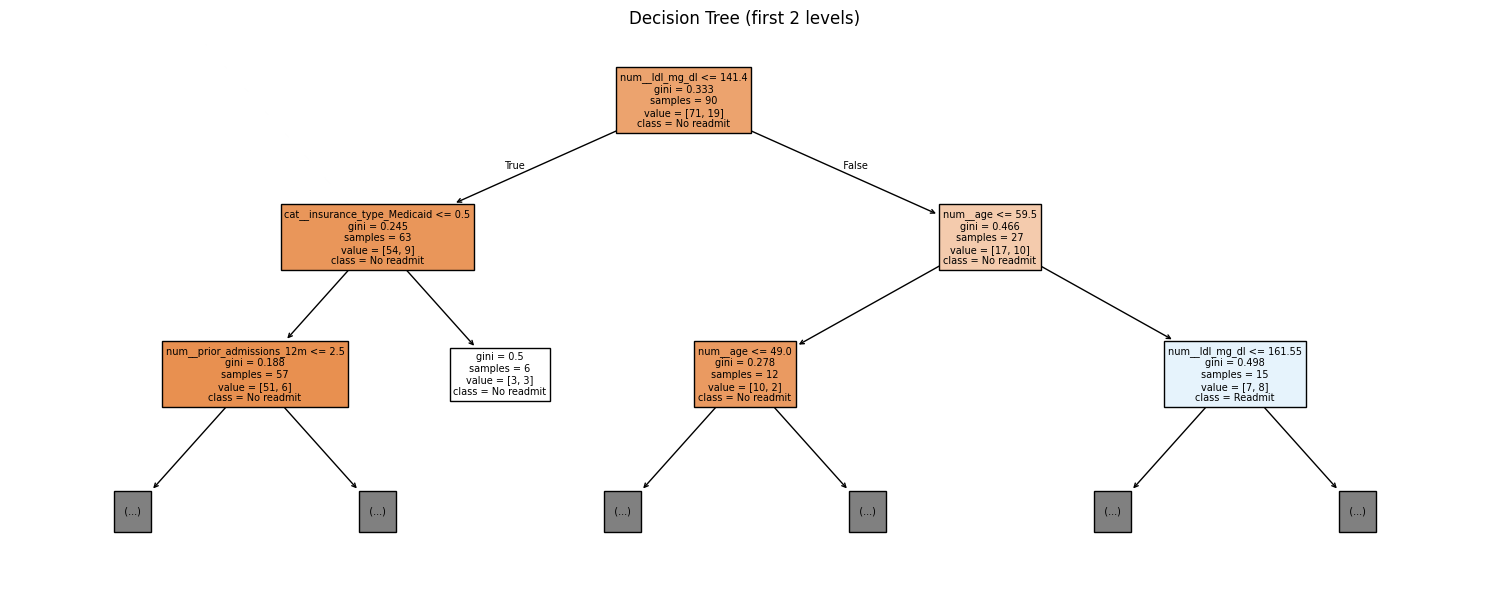

In [22]:
tree_feature_names = tree_model.named_steps['prep'].get_feature_names_out()
fig, ax = plt.subplots(figsize=(15, 6))
plot_tree(
    tree_model.named_steps['clf'],
    feature_names=tree_feature_names,
    class_names=['No readmit', 'Readmit'],
    filled=True,
    max_depth=2,
    ax=ax,
)
ax.set_title('Decision Tree (first 2 levels)')
plt.tight_layout()
plt.show()


## Step 7: Error Analysis - Who Did We Miss?
Focus on false negatives because missed high-risk patients may not receive interventions.


In [23]:
pred_df = X_test.copy()
pred_df['encounter_id'] = ids_test.values
pred_df['actual_readmit_30d'] = y_test.values
pred_df['lr_probability'] = lr_proba
pred_df['lr_pred_0_50'] = (lr_proba >= 0.50).astype(int)
pred_df['tree_probability'] = tree_proba
pred_df['tree_pred_0_50'] = (tree_proba >= 0.50).astype(int)

false_negatives = pred_df[(pred_df['actual_readmit_30d'] == 1) & (pred_df['lr_pred_0_50'] == 0)].copy()
false_negatives = false_negatives.sort_values('lr_probability', ascending=True)

print(f'False negatives (Logistic Regression @ 0.50): {len(false_negatives)}')
display(false_negatives[['encounter_id', 'age', 'sbp', 'ldl_mg_dl', 'smoke', 'comorbidity_count', 'prior_admissions_12m', 'lr_probability']].head(10).round(3))


False negatives (Logistic Regression @ 0.50): 5


,encounter_id,age,sbp,ldl_mg_dl,smoke,comorbidity_count,prior_admissions_12m,lr_probability
42,10045,65.0,146.5,59.600,0,2.0,0.0,0.017
30,10033,57.0,92.8,153.133,1,3.0,0.0,0.103
96,10104,69.0,140.9,66.000,0,3.0,2.0,0.121
83,10089,61.0,134.0,151.400,0,3.0,1.0,0.160
46,10049,65.0,144.6,129.900,0,1.0,3.0,0.407


## Step 8: Save Predictions for Module 4
Module 4 will go deeper into evaluation and threshold policy decisions.


In [24]:
out_path = DATA_PATH.parent / 'module_03_test_predictions.csv'
pred_df[['encounter_id', 'actual_readmit_30d', 'lr_probability', 'lr_pred_0_50', 'tree_probability', 'tree_pred_0_50']]    .to_csv(out_path, index=False)

print(f'Saved test prediction file to {out_path}')
display(pred_df.head(8).round(3))


Saved test prediction file to ../data/module_03_test_predictions.csv


,age,sex_female,sbp,ldl_mg_dl,smoke,comorbidity_count,prior_admissions_12m,insurance_type,race_group,encounter_id,actual_readmit_30d,lr_probability,lr_pred_0_50,tree_probability,tree_pred_0_50
96,69.0,1,140.9,66.000,0,3.0,2.0,Medicare,White,10104,1,0.121,0,0.045,0
31,75.0,0,132.6,125.678,0,3.0,0.0,Commercial,Asian,10034,0,0.056,0,0.045,0
106,64.0,1,134.0,155.900,0,2.0,2.0,Commercial,Other,10115,0,0.180,0,0.857,1
1,60.0,1,138.3,140.500,1,0.0,0.0,Commercial,Asian,10002,0,0.084,0,0.045,0
104,58.0,0,144.6,154.680,1,2.0,0.0,Commercial,Other,10112,0,0.148,0,0.000,0
4,65.0,1,134.4,149.300,1,1.0,1.0,Medicaid,Hispanic,10005,0,0.771,1,0.857,1
49,50.0,0,116.5,110.596,0,1.0,0.0,Commercial,White,10052,0,0.006,0,0.045,0
67,47.0,1,152.4,158.160,0,4.0,1.0,Commercial,White,10070,0,0.119,0,0.400,0


## Wrap-up: Key Takeaways
- You followed a full end-to-end clinical ML pipeline from problem framing to saved predictions.
- You trained your first two baseline clinical prediction models.
- Accuracy alone is not enough in medicine; sensitivity/specificity trade-offs matter.
- Threshold policy can change who gets flagged for intervention.
- Error analysis helps identify where the model may fail clinically.
- In Module 4, we will formalize evaluation beyond a single threshold.
